In [2]:
import scipy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt 
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.metrics import r2_score 
import statsmodels.api as sm 
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.arima_model import ARIMA 

/Users/mac/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
%matplotlib inline

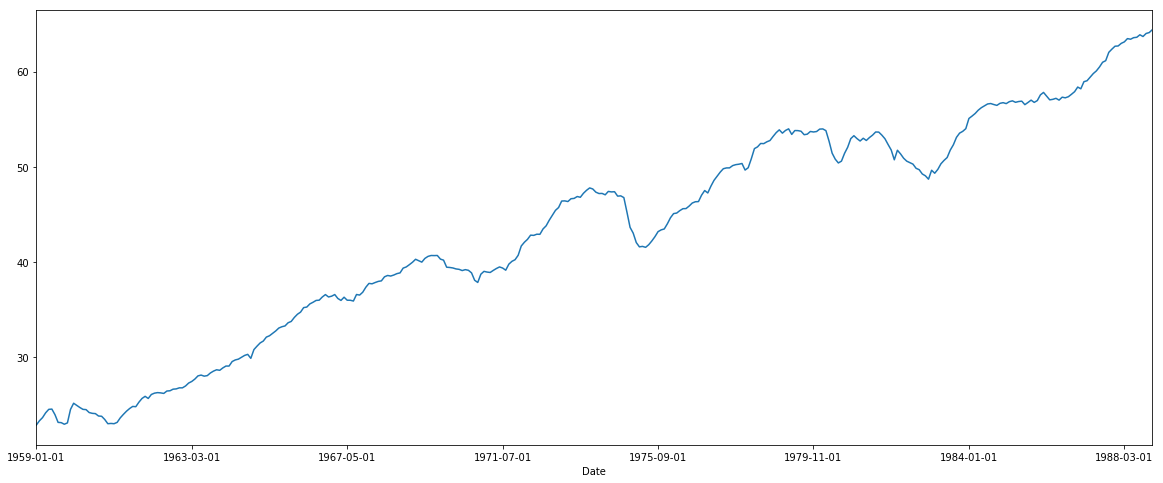

In [4]:
data = pd.read_csv('training.csv') 
ts = pd.Series(np.asarray(data['Value'], dtype=np.float), index=data['Date']) 
ts.cumsum() 
ts.plot(figsize=(20, 8))

In [5]:
def plotStats(ts): 
    ts.plot(color='b', legend=True, figsize=(20, 8), label='original row') 
    ts.rolling(window=12,center=False).mean().plot(color='g', legend=True, label='mean') 
    ts.rolling(window=12, center=False).std().plot(color='r', legend=True, label = 'std') 

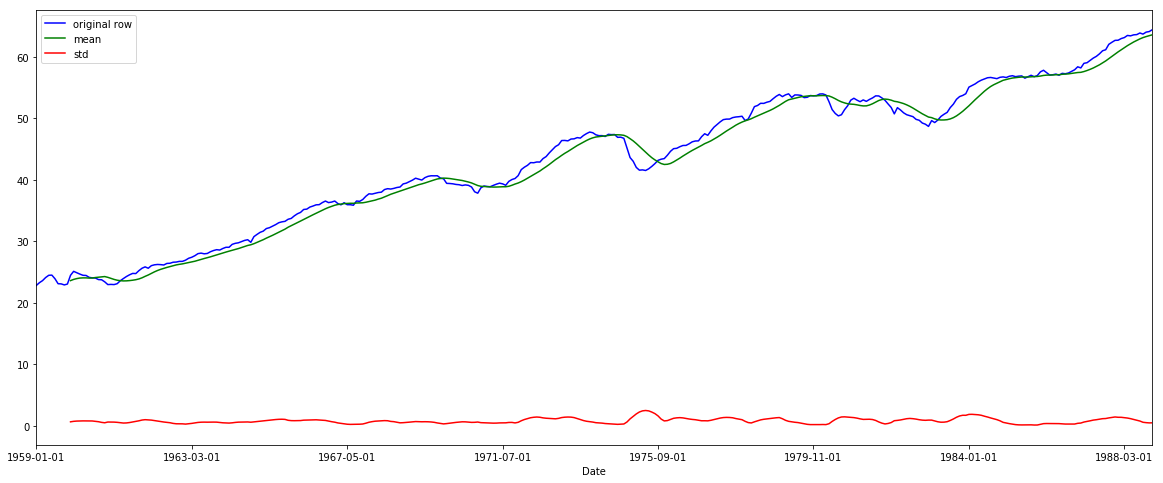

In [6]:
plotStats(ts)

In [7]:
def dfTest(ts, isPrint=True): 
    test = sm.tsa.adfuller(ts) 
    if isPrint: 
        print ('adf: ', test[0])
        print ('p-value: ', test[1]) 
        print ('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        if isPrint: 
            print ('have unit roots, a number is not stationary')
            return False 
        else: 
            if isPrint: 
                print ('unit roots there, a number of stationary')
        return True 
    return False 

In [8]:
dfTest(ts)

adf:  -0.253391179928
p-value:  0.931851042299
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
have unit roots, a number is not stationary


False

In [9]:
data.reset_index(inplace=True) 
data['Date'] = pd.to_datetime(data['Date']) 
data = data.set_index('Date') 
decomp = seasonal_decompose(data.Value) 

def showPlot(x, title=''): 
    plt.figure(figsize=(20, 4)) 
    plt.plot(x) 
    plt.title(title) 
    plt.show() 

In [10]:
trend = decomp.trend 
resid = decomp.resid 
seasonal = decomp.seasonal 

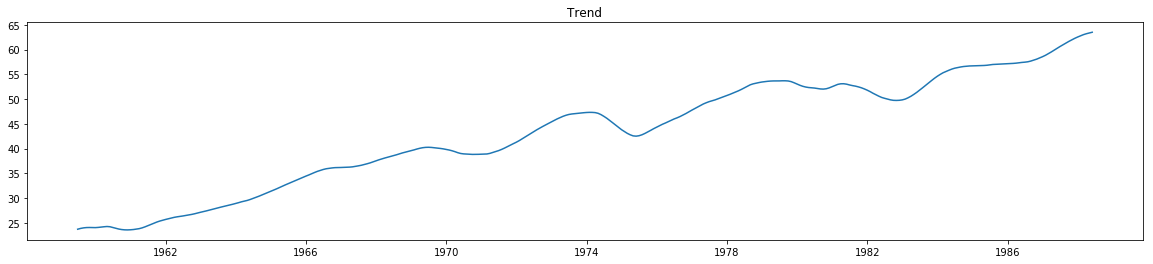

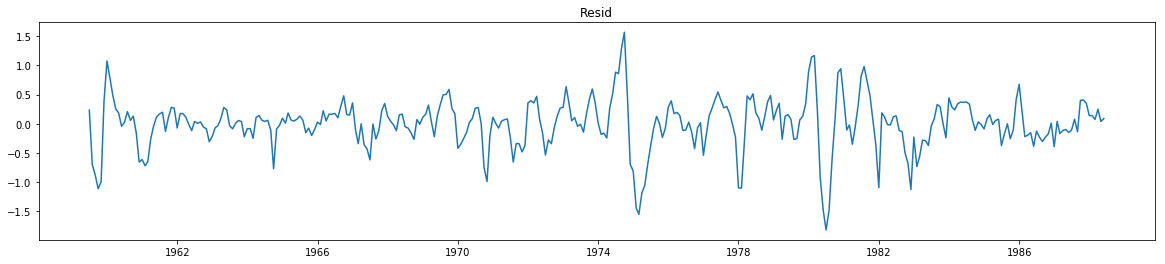

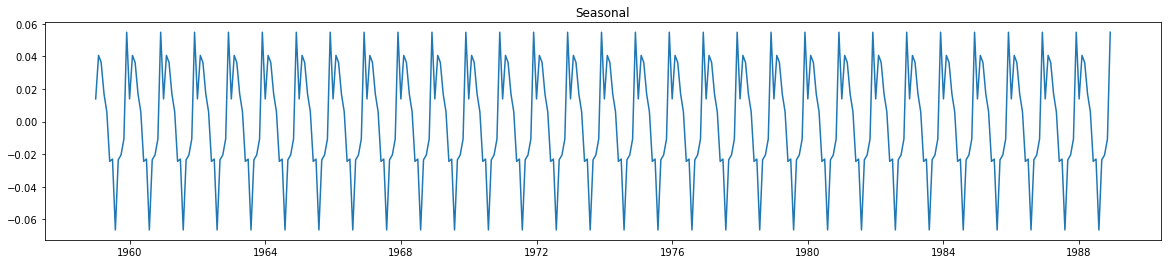

In [11]:
showPlot(trend, 'Trend') 
showPlot(resid, 'Resid') 
showPlot(seasonal, 'Seasonal')

DatetimeIndex(['1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01',
               ...
               '1988-03-01', '1988-04-01', '1988-05-01', '1988-06-01',
               '1988-07-01', '1988-08-01', '1988-09-01', '1988-10-01',
               '1988-11-01', '1988-12-01'],
              dtype='datetime64[ns]', name='Date', length=360, freq=None)
adf:  -0.861576033358
p-value:  0.800362576153
Critical values:  {'1%': -3.4503224123605194, '5%': -2.8703384787266608, '10%': -2.5714576124885218}
have unit roots, a number is not stationary


False

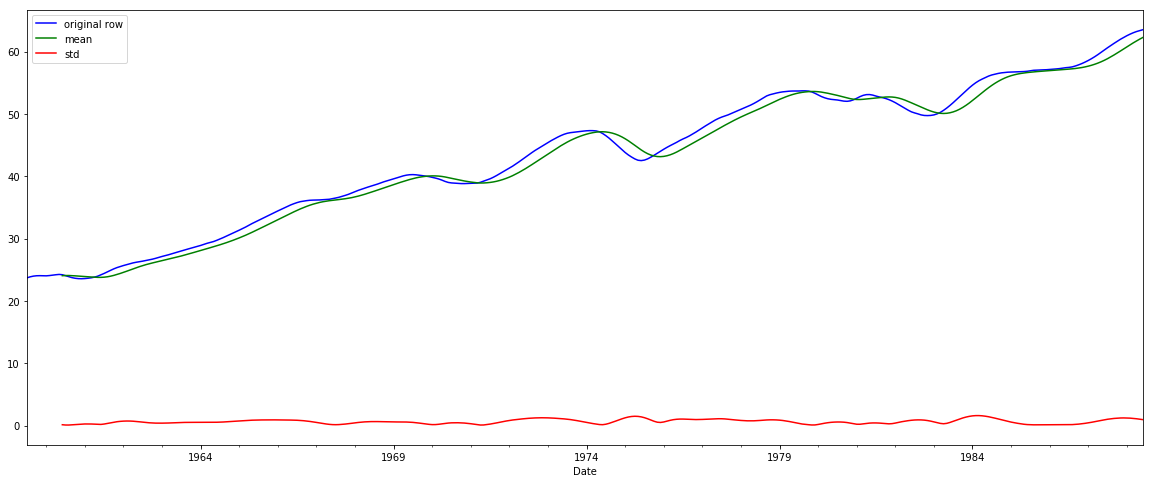

In [12]:
print (trend.keys()) 
trend.dropna(inplace=True) 
tsTrend = pd.Series(np.asarray(trend, dtype=np.float), index=trend.index) 
plotStats(tsTrend) 
dfTest(tsTrend)

adf:  -7.48556383377
p-value:  4.64909667469e-11
Critical values:  {'1%': -3.4496162602188187, '5%': -2.870028369720798, '10%': -2.5712922615505627}


False

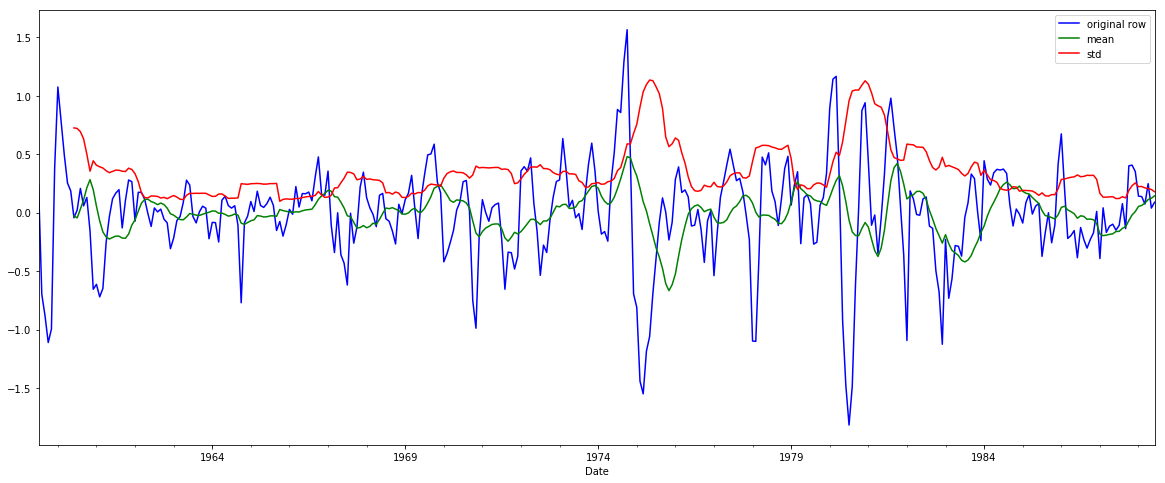

In [13]:
resid.dropna(inplace=True) 
tsResid = pd.Series(np.asarray(resid, dtype=np.float), index=resid.index) 
tsResid.cumsum() 
plotStats(tsResid) 
dfTest(tsResid)

adf:  -1.45267497959e+14
p-value:  0.0
Critical values:  {'1%': -3.4492815848836296, '5%': -2.8698813715275406, '10%': -2.5712138845950587}


False

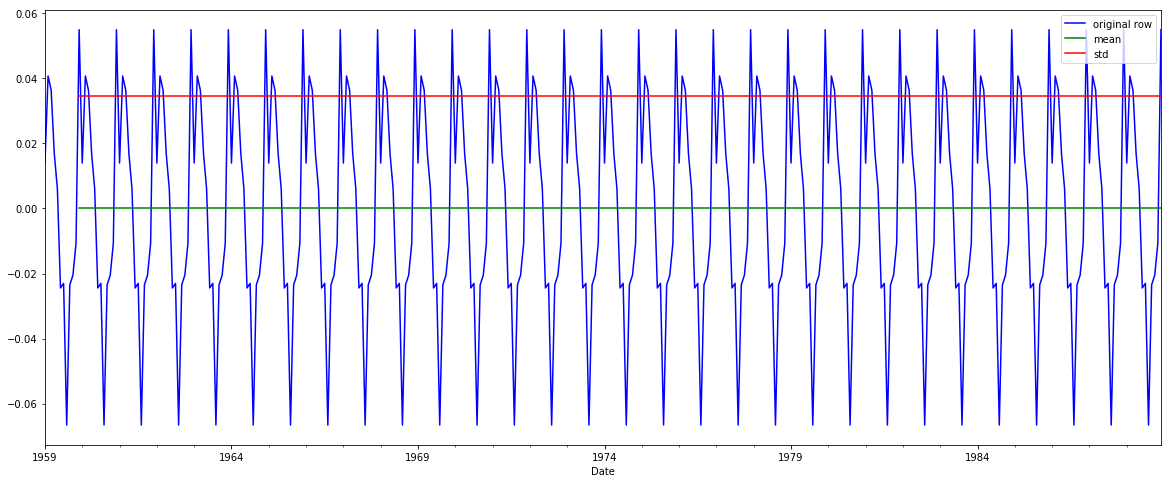

In [14]:
seasonal.dropna(inplace=True) 
tsSeasonal = pd.Series(np.asarray(seasonal, dtype=np.float), index=seasonal.index) 
tsSeasonal.cumsum() 
plotStats(tsSeasonal) 
dfTest(tsSeasonal)

In [15]:
def findOrder(ts, isPrint=False): 
    integrationOrder = 0 
    while not dfTest(ts, isPrint): 
        ts = ts.diff(periods=1).dropna() 
        integrationOrder += 1 
    return integrationOrder

In [16]:
k = findOrder(ts) 
print (k)

0


In [17]:
log_shift_ts = (np.log(ts) - np.log(ts).shift()) 
log_shift_ts.dropna(inplace=True) 
acf = acf(log_shift_ts) 
pacf = pacf(log_shift_ts, method='ols') 

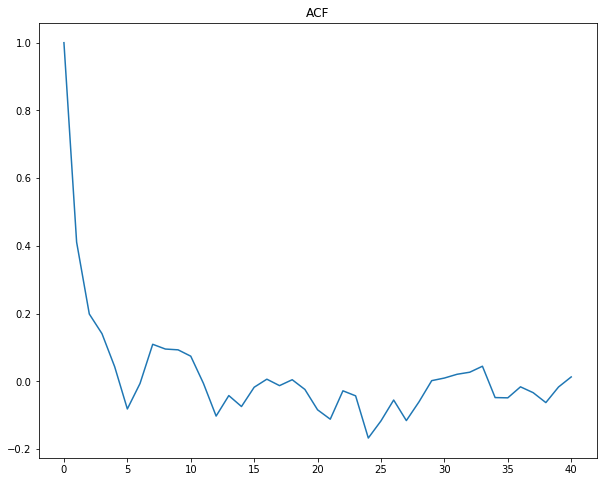

In [18]:
plt.figure(figsize=(10, 8)) 
plt.plot(acf) 
plt.title('ACF') 
plt.show() 

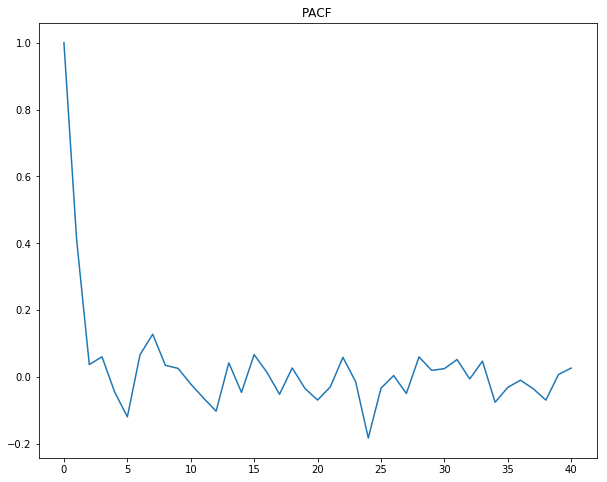

In [19]:
plt.figure(figsize=(10, 8)) 
plt.plot(pacf) 
plt.title('PACF') 
plt.show()

In [20]:
ts.index = pd.to_datetime(ts.index) 
ts_log = np.log(ts) 
#print ts_log 
model = ARIMA(ts_log, order=(int(pacf[0]), k, int(acf[0]))) 
fit_val = model.fit(disp=-1) 
pred = fit_val.fittedvalues 

R^2 value: 

ValueError: Found input variables with inconsistent numbers of samples: [359, 360]

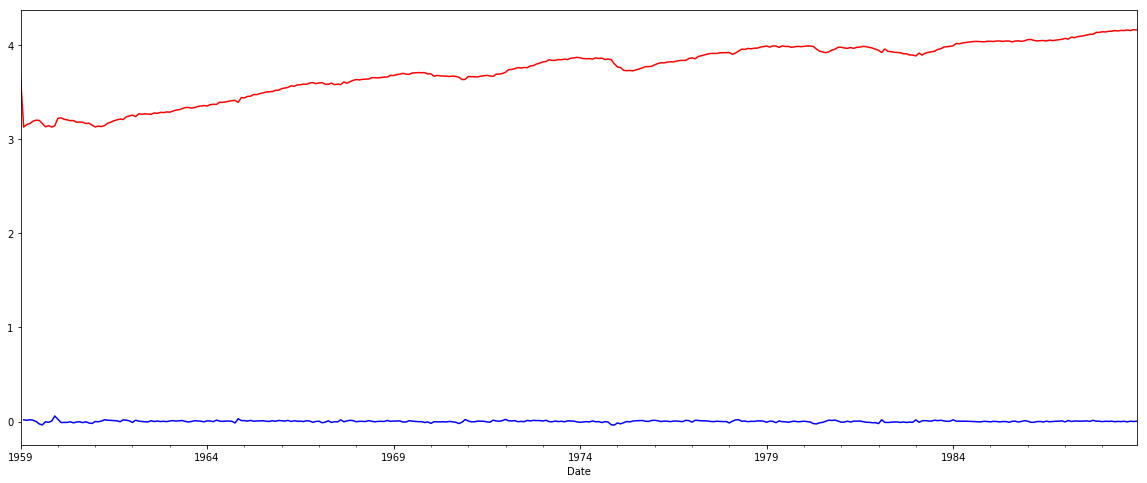

In [21]:
ts_log_diff = (np.log(ts) - np.log(ts).shift()) 
ts_log_diff.dropna(inplace=True) 
pred.plot(figsize=(20, 8), color='r') 
ts_log_diff.plot(figsize=(20, 8), color='b')
print ('R^2 value: ', end = '')
print (r2_score(ts_log_diff, pred))

In [25]:
dataTest = pd.read_csv('testing.csv') 
tsTest = pd.Series(np.asarray(dataTest['Value'], dtype=np.float), index=dataTest['Date']) 
tsTest.cumsum() 

Date
1959-01-01       22.8331
1959-02-01       46.1133
1959-03-01       69.7289
1959-04-01       93.8475
1959-05-01      118.3295
1959-06-01      142.8394
1959-07-01      166.7624
1959-08-01      189.8749
1959-09-01      212.9595
1959-10-01      235.8764
1959-11-01      258.9331
1959-12-01      283.4151
1960-01-01      308.5399
1960-02-01      333.4411
1960-03-01      358.1187
1960-04-01      382.6007
1960-05-01      407.0547
1960-06-01      431.2013
1960-07-01      455.2641
1960-08-01      479.2989
1960-09-01      503.0822
1960-10-01      526.8376
1960-11-01      550.2576
1960-12-01      573.2304
1961-01-01      596.2312
1961-02-01      619.2040
1961-03-01      642.3166
1961-04-01      665.9043
1961-05-01      689.8553
1961-06-01      714.1417
                 ...    
1986-07-01    13828.1329
1986-08-01    13885.3873
1986-09-01    13942.7583
1986-10-01    14000.3859
1986-11-01    14058.2859
1986-12-01    14116.6722
1987-01-01    14174.8746
1987-02-01    14233.8252
1987-03-01    14292.

In [26]:
predict = fit_val.predict('1988-12-01', '1993-12-01') 
predict = predict['1989-01-01':]

ValueError: Found input variables with inconsistent numbers of samples: [360, 60]

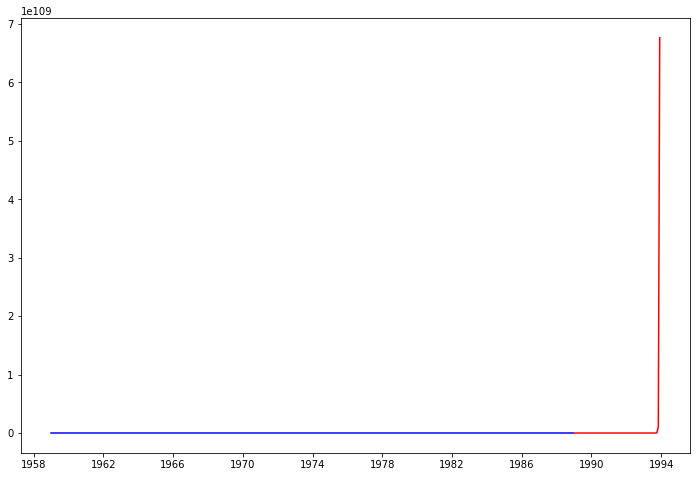

In [27]:
predict[0] += np.log(tsTest[0]) 
predict = predict.cumsum() 
predict = np.exp(predict) 
plt.figure(figsize=(12,8)) 
plt.plot(predict, color='r') 
plt.plot(tsTest, color='b') 
print ('R2 Score: %.4f' % r2_score(tsTest, predict))